
# 🧪 **Results Analysis - Optimization and Hypothesis Testing**  

The objective of this notebook is to analyze the intermediate results obtained by optimizations (with Optuna and Gridseacrch) of the three trained models: Generalized Linear Model (GLM), Generalized Additive Model (GAM) and Symbolic Regression (SR).

***

### 📚 **Importing libraries**

In [86]:
import optuna
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_timeline

import os
import pickle
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from ucimlrepo import fetch_ucirepo
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import KFold
from sklearn.cluster import Birch

from sklearn.preprocessing import StandardScaler

from statsmodels.genmod.families import Gamma, Gaussian, InverseGaussian
from statsmodels.genmod.families.links import log as Log, identity as Identity, inverse_power as InversePower, inverse_squared as InverseSquared
import statsmodels.api as sm

import pygam
from pygam import s
import statistics as st

### **Generalized Linear Model (GLM) - Grid Search** 

In [23]:
df_gs_glm = pd.read_csv("../Other_files/gridsearch_glm_results.csv").drop(columns = "Unnamed: 0")
df_gs_glm.loc[df_gs_glm["RMSE"].idxmin()]

Family     Gaussian
Link            log
RMSE      15.102621
Name: 3, dtype: object

Grid Search, considering the limited number of families and link functions, shows as the best technique for optimizing GLM without clustering. 

### **Generalized Linear Model (GLM) with clustering - Bayesian Search** 

In [24]:
study_name = "optimization_clusters_glm_teste21_07_2025_16_46_28"
storage_url = "sqlite:///../Optuna_files/optimization_glm_bayesian.db"

study_glm_bs = optuna.load_study(study_name=study_name, storage=storage_url)


##### **Best trial**

In [25]:
print(f"The best trial had RMSE equal to {study_glm_bs.best_value:.2f}")

The best trial had RMSE equal to 13.73


In [26]:
print(f"The best params were: {study_glm_bs.best_params}")

The best params were: {'clusterer': 'birch', 'n_clusters_birch': 10, 'branching_factor': 700, 'threshold': 0.18251719168858943, 'distribution': 'gaussian', 'link_gaussian': 'identity'}


The link function was different from the optimization without clustering ("log" and "identity", respectively)

##### **Optimization history**

First, it´s necessary to remove outliers and concat two params that are used for the same thing: "params_n_clusters" and "params_n_clusters_bkmeans". Both are used to count the number of clusters, but for different clusteres.


In [27]:
df_glm = study_glm_bs.trials_dataframe()
df_filter_glm = df_glm[(df_glm["state"] != "PRUNED") & (df_glm["value"] <= 10e1)]

df_filter_glm["n_clusters"] = (
    df_filter_glm["params_n_clusters"]
    .fillna(df_filter_glm["params_n_clusters_bkmeans"])
    .fillna(df_filter_glm["params_n_clusters_birch"])
)

C:\Users\julia24002\AppData\Local\Temp\ipykernel_26512\1450389014.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



This plot shows the study optimization history, by showing the objective value for each Optuna trial. Besides that, we can see the clusterer that was used and the number of clusters chosen.

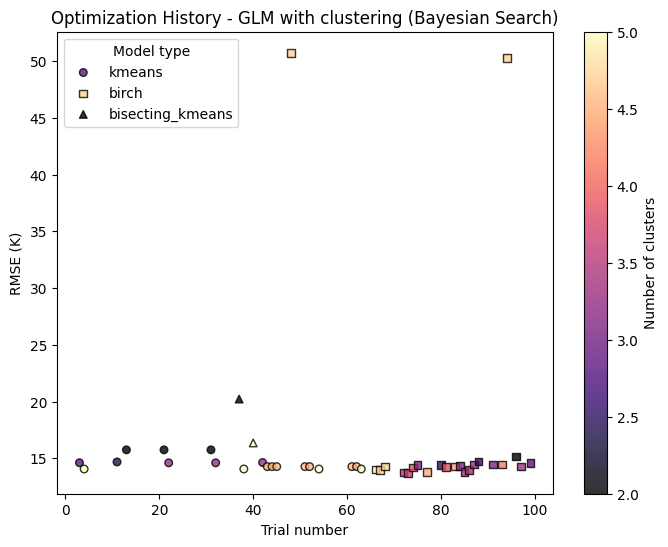

In [28]:
markers = {"kmeans": "o", "birch": "s", "bisecting_kmeans": "^"}

plt.figure(figsize=(8,6))

for model, marker in markers.items():
    subset = df_filter_glm[df_filter_glm["params_clusterer"] == model]
    plt.scatter(
        subset["number"],
        subset["value"],
        s=30,
        c=subset["n_clusters"],
        cmap="magma",
        marker=marker,
        label=model,
        edgecolor="black", 
        alpha=0.8
    )

plt.title("Optimization History - GLM with clustering (Bayesian Search)")
plt.xlabel("Trial number")
plt.ylabel("RMSE (K)")
plt.colorbar(label="Number of clusters")
plt.legend(title="Model type")
plt.show()


It´s possible to notice that trials with Birch presented better results and the number of clusteres used varied between one and eleven.

##### **Hyperparameter Importances**

Plot hyperparameter importances based on the Optuna attempts.

In [29]:
plot_param_importances(study_glm_bs)

Clustered shows off as the most important feature, with 96% of contribution.

In [30]:
plot_timeline(study_glm_bs)


It is noticeable that, in the beginning, the algorithm faced difficulties in generating valid trials. However, as the process progressed, several complete trials were successfully obtained.

### **Generalized Linear Model (GLM) with clustering - Random Search** 

In [31]:
study_name = "optimization_clusters_glm_teste21_07_2025_16_50_13"
storage_url = "sqlite:///../Optuna_files/optimization_glm_random_search.db"

study_glm_rs = optuna.load_study(study_name=study_name, storage=storage_url)

##### **Best trial**

In [32]:
print(f"The best trial had RMSE equal to {study_glm_rs.best_value:.2f}")

The best trial had RMSE equal to 13.75


In [33]:
print(f"The best params were: {study_glm_rs.best_params}")

The best params were: {'clusterer': 'birch', 'n_clusters_birch': 11, 'branching_factor': 990, 'threshold': 0.3102963536234391, 'distribution': 'gaussian', 'link_gaussian': 'identity'}


##### **Optimization history**

In [34]:
df_glm_rs = study_glm_rs.trials_dataframe()

df_filter_glm_rs = df_glm_rs[(df_glm_rs["state"] != "PRUNED") & (df_glm_rs["value"] <= 10e1)]

df_filter_glm_rs["n_clusters"] = (
    df_filter_glm_rs["params_n_clusters"]
    .fillna(df_filter_glm_rs["params_n_clusters_bkmeans"])
    .fillna(df_filter_glm_rs["params_n_clusters_birch"])
)


C:\Users\julia24002\AppData\Local\Temp\ipykernel_26512\3062556667.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



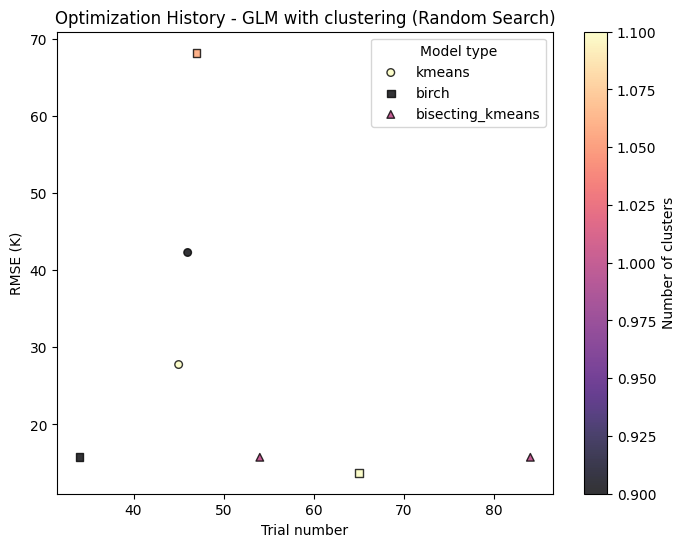

In [35]:
markers = {"kmeans": "o", "birch": "s", "bisecting_kmeans": "^"}

plt.figure(figsize=(8,6))

for model, marker in markers.items():
    subset = df_filter_glm_rs[df_filter_glm_rs["params_clusterer"] == model]
    plt.scatter(
        subset["number"],
        subset["value"],
        s=30,
        c=subset["n_clusters"],
        cmap="magma",
        marker=marker,
        label=model,
        edgecolor="black", 
        alpha=0.8
    )

plt.title("Optimization History - GLM with clustering (Random Search)")
plt.xlabel("Trial number")
plt.ylabel("RMSE (K)")
plt.colorbar(label="Number of clusters")
plt.legend(title="Model type")
plt.show()


Now we can clearly see that most attempts are still close to 15, which makes sense considering that the best attempt reached a value of 13.75. Besides that, it is evident that the prefered cluster was Birch and more clusters,, in general, led to a better result.

##### **Hyperparameter Importances**

Plot hyperparameter importances based on the Optuna attempts.

In [36]:
plot_param_importances(study_glm_rs)

Again, clusterer seems like the most important feature for Optuna Optimization.

##### **Timeline plot**

Plot the timeline of a study, indicating complete and pruned trials.

In [37]:
plot_timeline(study_glm_rs)


There were many pruned trials, likely due to a combination of random sampling and a numerically unstable model.

### **Generalized Linear Model (GAM) - Bayesian Search** 

In [38]:
study_name = "optimization_gam_teste25_09_2025_21_56_16" 

storage_url = f"sqlite:///../Optuna_files/optimization_gam_without_clustering.db"

study_gam = optuna.load_study(study_name=study_name, storage=storage_url)

#### **Best trial**

In [39]:
print(f"The best trial had RMSE equal to {study_gam.best_value:.2f}")

The best trial had RMSE equal to 13.14


In [40]:
print(f"The best params were {study_gam.best_params}")

The best params were {'distribution': 'normal', 'link_gaussian': 'identity', 'lam': 0.4122645931880113, 'n_splines': 25}


#### **Optimization history**

In [48]:
df_gam = study_gam.trials_dataframe()
df_filter_gam = df_gam[(df_gam["state"] != "PRUNED") & (df_gam["value"] <= 10e1)]

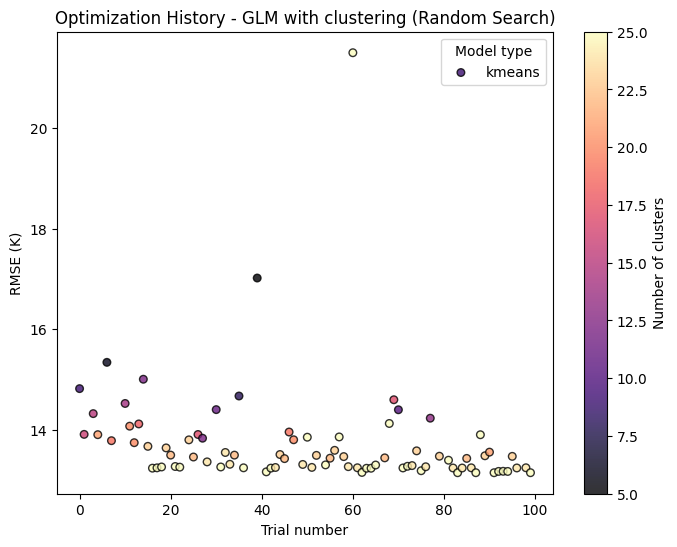

In [50]:

plt.figure(figsize=(8,6))

plt.scatter(
        df_filter_gam["number"],
        df_filter_gam["value"],
        s=30,
        c=df_filter_gam["params_n_splines"],
        cmap="magma",
        marker=marker,
        label=model,
        edgecolor="black", 
        alpha=0.8
)

plt.title("Optimization History - GLM with clustering (Random Search)")
plt.xlabel("Trial number")
plt.ylabel("RMSE (K)")
plt.colorbar(label="Number of clusters")
plt.legend(title="Model type")
plt.show()

From the graph, it is possible to observe that a larger number of splines led to a lower RMSE. In addition, the normal distribution was preferred compared to the gamma distribution.

#### **Hyperparameter importance**

In [51]:
plot_param_importances(study_gam)

In general, the optimized parameter was lam - what makes sense considering that lam has a infinite number of possibilities (continuous float).

#### **Timeline plot**

In [52]:
plot_timeline(study_gam)

Many complete trials, indicating that the limitation of possible combinations between distribution and link functions was effective for avoid pruned trials.

### **Generalized Additive Model (GAM) with clustering - Bayesian Search**

In [53]:
study_name = "optimization_clusters_gam_teste21_07_2025_16_52_45" 

storage_url = f"sqlite:///../Optuna_files/optimization_gam_bayesian.db"

study_gam_bs = optuna.load_study(study_name=study_name, storage=storage_url)

#### **Best trial**

In [54]:
print(f"The best trial had RMSE equal to {study_gam_bs.best_value:.2f}")

The best trial had RMSE equal to 10.21


In [55]:
print(f"The best params were {study_gam_bs.best_params}")

The best params were {'clusterer': 'bisecting_kmeans', 'n_clusters_bkmeans': 24, 'bisecting_strategy': 'largest_cluster', 'distribution': 'normal', 'link_gaussian': 'identity', 'lam': 0.2457079020965402, 'n_splines': 20}


#### **Optimization history**

In [56]:
df_gam_bs = study_gam_bs.trials_dataframe()
df_filter_gam_bs = df_gam_bs[(df_gam_bs["state"] != "PRUNED") & (df_gam_bs["value"] <= 10e1)]

df_filter_gam_bs["n_clusters"] = (
    df_filter_gam_bs["params_n_clusters"]
    .fillna(df_filter_gam_bs["params_n_clusters_bkmeans"])
    .fillna(df_filter_gam_bs["params_n_clusters_birch"])
)

C:\Users\julia24002\AppData\Local\Temp\ipykernel_26512\3988603115.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



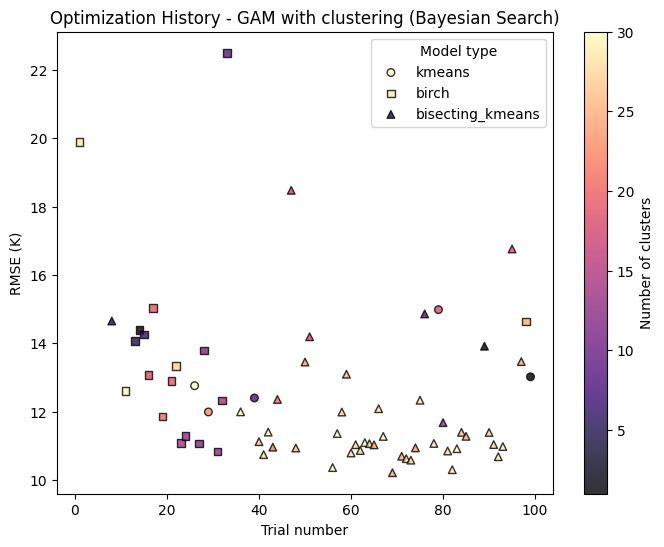

In [57]:
markers = {"kmeans": "o", "birch": "s", "bisecting_kmeans": "^"}

plt.figure(figsize=(8,6))

for model, marker in markers.items():
    subset = df_filter_gam_bs[df_filter_gam_bs["params_clusterer"] == model]
    plt.scatter(
        subset["number"],
        subset["value"],
        s=30,
        c=subset["n_clusters"],
        cmap="magma",
        marker=marker,
        label=model,
        edgecolor="black", 
        alpha=0.8
    )

plt.title("Optimization History - GAM with clustering (Bayesian Search)")
plt.xlabel("Trial number")
plt.ylabel("RMSE (K)")
plt.colorbar(label="Number of clusters")
plt.legend(title="Model type")
plt.show()

The values are lower compared to those obtained with the GLM, which justifies the better results observed. Bisecting k-means emerges as the clustering method that yields the best performance. Additionally, there are fewer pruned trials. This can be explained by the number of parameters involved in the GAM: a suitable combination of distribution and link function, which are often responsible for model instability, may have been found early in the optimization process. As a result, subsequent trials were more focused on tuning numerical parameters, such as the regularization term (lambda) and the number of clusters, which have less impact on whether a trial is pruned.

#### **Hyperparameter Importance**

In [58]:
plot_param_importances(study_gam_bs)

In the case of GAM, the most important hyperparameter was lambda, which represents the regularization strenght.

#### **Timeline plot**

In [59]:
plot_timeline(study_gam_bs)

The time was longer compared with GLM, but there were fewer pruned trials.

### **Generalized Additive Model (GAM) with clustering - Random Search**

In [60]:
study_name = "optimization_clusters_gam_teste31_07_2025_09_51_57" 

storage_url = f"sqlite:///../Optuna_files/optimization_gam_random_search.db"

study_gam_rs = optuna.load_study(study_name=study_name, storage=storage_url)

##### **Best trial**

In [61]:
print(f"The best trial had RMSE equal to {study_gam_rs.best_value:.2f}")

The best trial had RMSE equal to 10.95


In [62]:
print(f"The best params were {study_gam_rs.best_params}")

The best params were {'clusterer': 'birch', 'n_clusters_birch': 25, 'branching_factor': 788, 'threshold': 0.5470948785370666, 'distribution': 'normal', 'link_gaussian': 'identity', 'lam': 0.7163145957304842, 'n_splines': 22}


##### **Optimization history**

In [63]:
df_gam_rs = study_gam_rs.trials_dataframe()
df_filter_gam_rs = df_gam_rs[(df_gam_rs["state"] != "PRUNED") & (df_gam_rs["value"] <= 10e1)]

df_filter_gam_rs["n_clusters"] = (
    df_filter_gam_rs["params_n_clusters"]
    .fillna(df_filter_gam_rs["params_n_clusters_bkmeans"])
    .fillna(df_filter_gam_rs["params_n_clusters_birch"])
    )

C:\Users\julia24002\AppData\Local\Temp\ipykernel_26512\2068861693.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



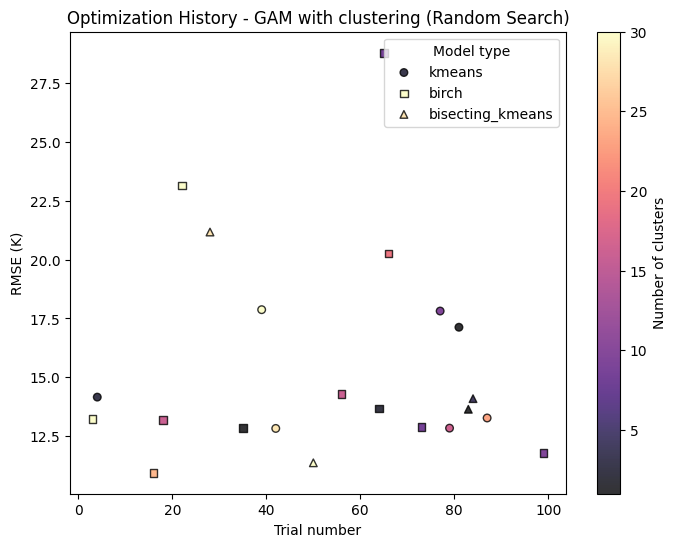

In [64]:
markers = {"kmeans": "o", "birch": "s", "bisecting_kmeans": "^"}

plt.figure(figsize=(8,6))

for model, marker in markers.items():
    subset = df_filter_gam_rs[df_filter_gam_rs["params_clusterer"] == model]
    plt.scatter(
        subset["number"],
        subset["value"],
        s=30,
        c=subset["n_clusters"],
        cmap="magma",
        marker=marker,
        label=model,
        edgecolor="black", 
        alpha=0.8
    )

plt.title("Optimization History - GAM with clustering (Random Search)")
plt.xlabel("Trial number")
plt.ylabel("RMSE (K)")
plt.colorbar(label="Number of clusters")
plt.legend(title="Model type")
plt.show()

For the first time affinity propagation was chosen as clusterer and result in a valid trial. However, this type of clustering didn´t provided a good result at all.

##### **Hyperparameter Importances**

In [65]:
plot_param_importances(study_gam_rs)

As the result showed by bayesian search, lam was the most important hyperparameter.

##### **Timeline plot**

In [66]:
plot_timeline(study_gam_rs)

This type of search resulted in more pruned trials. Probably the random search resulted in more pruned trials. 

### **Hypothesis Test: Proving $H_2$**

In this project, our second objective is to verify whether clustering can lead models to better performance. Based on this, we can perform a t-Student test for the GLM and GAM results. The hypotheses are:

* $H_0$: The difference between the results of the test without clustering and with clustering is not statistically significant;

* $H_1$: The difference between the results of the test without clustering and with clustering is statistically significant.

First of all, we need to train the models with the optimizated hyperparameters.

##### **Importing data**

In [73]:
superconductivity_data = fetch_ucirepo(id=464)

X = superconductivity_data.data.features
y = superconductivity_data.data.targets
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=1702
    )

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_test = np.clip(y_test, 1e-6, None)
y_train = np.clip(y_train, 1e-6, None)


##### **GLM**

In [83]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index = X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

kf = KFold(n_splits=10, shuffle=True, random_state=1203)
cv_glm = {}

for split, (train_idx, test_idx) in enumerate(kf.split(X_train_scaled)):
    X_train_cv, X_test_cv = X_train_scaled.iloc[train_idx], X_train_scaled.iloc[test_idx]
    y_train_cv, y_test_cv = y_train.iloc[train_idx], y_train.iloc[test_idx]

    model = sm.GLM(y_train_cv, X_train_cv, family=sm.families.Gaussian(link=sm.families.links.Log()))
    glm = model.fit()

    y_pred = glm.predict(X_test_cv)

    rmse = root_mean_squared_error(y_test_cv, y_pred)
    cv_glm[split] = rmse

fold_values = list(cv_glm.values())
cv_glm["Mean"] = st.mean(fold_values)
cv_glm["Median"] = st.median(fold_values)

In [84]:
cv_glm

{0: 16.005547617760115,
 1: 16.008182838582037,
 2: 15.810517473345028,
 3: 15.451108211666265,
 4: 15.373382004156642,
 5: 15.555057946602918,
 6: 15.858666902882364,
 7: 16.23108476673221,
 8: 15.792837384044258,
 9: 15.45538931746751,
 'Mean': 15.754177446323935,
 'Median': 15.801677428694642}

In [85]:
glm_folds = list(cv_glm.values())[:-2]

##### **Clustering GLM**

In [87]:
import sys
sys.path.append("../Main_Scripts")

from script_glm import Clustering_GLM, cross_validation

clusterer_glm_cluster = Birch(n_clusters=10,
                            branching_factor=700,
                            threshold=0.18251719168858943)

cv_glm_results = cross_validation(
    X = X_train_scaled, 
    y = y_train, 
    clusterer = clusterer_glm_cluster, 
    distribution=sm.families.Gaussian(link=Identity()),   
    random_seed=1203, 
    n_splits = 10         
)
                                                          


c:\Users\julia24002\.conda\envs\glm_gam\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning:

The identity link alias is deprecated. Use Identity instead. The identity link alias will be removed after the 0.15.0 release.

c:\Users\julia24002\.conda\envs\glm_gam\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but Birch was fitted with feature names

c:\Users\julia24002\.conda\envs\glm_gam\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but Birch was fitted with feature names

c:\Users\julia24002\.conda\envs\glm_gam\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but Birch was fitted with feature names

c:\Users\julia24002\.conda\envs\glm_gam\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but Birch was fitted with feature names

c:\Users\julia24002\.

In [88]:
cv_glm_results

{0: 14.397403738217896,
 1: 14.326387951857473,
 2: 13.039220010058106,
 3: 13.43390124623487,
 4: 13.333216345787376,
 5: 13.532512296746388,
 6: 13.374314592668286,
 7: 14.378108224732788,
 8: 18.77895981037897,
 9: 13.916388948463547,
 'Mean': 14.25104131651457,
 'Median': 13.724450622604968}

In [89]:
glm_clustering_folds = list(cv_glm_results.values())[:-2]

##### **Hypothesis Test**

First of all, we need to define confidence and significance for doing the hypothesis tests. 

In [90]:
CONFIDENCE = 0.95

SIGNIFICANCE = 1 - CONFIDENCE

Now, we can check if data follow a normal distribution (If both data follow this distribution, we can use student test), using Shapiro Wilk test.

In [91]:
shapiro_result1 = stats.shapiro(glm_folds)

pvalor = shapiro_result1.pvalue

print(pvalor)

0.5329424444132825


In [92]:
shapiro_result2 = stats.shapiro(glm_clustering_folds)

pvalor = shapiro_result2.pvalue

print(pvalor)

0.00015172146125069964


Since the cross-validation results do not follow a normal distribution, it is possible to apply the Wilcoxon signed-rank test, a non-parametric alternative to the paired t-test (paired because data is the same). This test evaluates whether the median difference between the paired results of both models is statistically significant.

The hypotheses are defined as follows:

* $H_0$: The median of the differences between the cross-validation results of both models is equal to zero;

* $H_1$ : The median of the differences between the cross-validation results is greater than zero, so the distribution from which glm_folds was sampled is stochastically greater than that of glm_clustering_folds.

In [93]:
wilcoxon = stats.wilcoxon(glm_folds, glm_clustering_folds, alternative="greater")

pvalor = wilcoxon.pvalue

pvalor

np.float64(0.0419921875)

So we accepted $H_0$ (0.042 < 0.05): The median of the difference between the CV results of the model with and without clustering is equal to 0, which means that clustering didn´t impact on the results.

##### **GAM**

In [94]:
cv_gam = {}

kf = KFold(n_splits=10, shuffle=True, random_state=1203)

split = 0
    
for train_idx, test_idx in kf.split(X_train):
        
    X_train_cv, X_test_cv = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_cv, y_test_cv = y_train.iloc[train_idx], y_train.iloc[test_idx]
            
    terms = s(0)
        
    for i in range(1, X_train.shape[1]):
        terms += s(i)
            
    model_gam = pygam.pygam.GAM(terms, 
                                distribution="normal", 
                                link="identity", 
                                lam=0.2457079020965402, 
                                n_splines=20)
    
    model_gam.fit(X_train_cv, y_train_cv)

    # Make the prediction
    y_pred = model_gam.predict(X_test_cv)

    # Calculate RMSE
    rmse = root_mean_squared_error(y_test_cv, y_pred)

    cv_gam[split] = rmse
    split += 1

fold_values = list(cv_gam.values())
cv_gam["Mean"] = st.mean(fold_values)
cv_gam["Median"] = st.median(fold_values)


In [95]:
cv_gam

{0: 13.539436279640586,
 1: 14.205275601938784,
 2: 13.080293677940773,
 3: 13.872400786204992,
 4: 13.373020621059634,
 5: 13.33093929296154,
 6: 13.518339627490661,
 7: 14.385891191833274,
 8: 13.329350434516446,
 9: 14.024487512167777,
 'Mean': 13.665943502575447,
 'Median': 13.528887953565624}

In [96]:
gam_folds = list(cv_gam.values())[:-2]

##### **Clustering GAM**

In [97]:
import sys
sys.path.append("../Main_Scripts")

from script_gam import Clustering_GAM, cross_validation
from sklearn.cluster import BisectingKMeans

clusterer_gam_cluster = BisectingKMeans(n_clusters=24,
                                        init = "k-means++",
                                        random_state = 1203,
                                        bisecting_strategy="largest_cluster")


clustering_gam = Clustering_GAM(clusterer_gam_cluster, "normal", "identity", 20, 0.2457079020965402)
cv_gam_results = cross_validation(X_train, y_train, clusterer_gam_cluster, "normal", "identity", 0.2457079020965402, 20, n_splits=10)

c:\Users\julia24002\.conda\envs\glm_gam\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but BisectingKMeans was fitted with feature names

c:\Users\julia24002\.conda\envs\glm_gam\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but BisectingKMeans was fitted with feature names

c:\Users\julia24002\.conda\envs\glm_gam\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but BisectingKMeans was fitted with feature names

c:\Users\julia24002\.conda\envs\glm_gam\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but BisectingKMeans was fitted with feature names

c:\Users\julia24002\.conda\envs\glm_gam\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but BisectingKMeans was fitted with feature names

c:\Users\julia24002\.conda\env

In [98]:
cv_gam_results

{0: 10.729465722254526,
 1: 12.121165728972676,
 2: 11.62216961668095,
 3: 11.054541056525292,
 4: 11.842880016253114,
 5: 11.905701532730411,
 6: 12.207463738929349,
 7: 11.689702113423676,
 8: 10.338568725822373,
 9: 11.693860052021511,
 'Mean': 11.520551830361388,
 'Median': 11.691781082722594}

In [99]:
gam_clustering_folds = list(cv_gam_results.values())[:-2]

##### **Hypothesis test**

We can made the same procedure from GLM, following the hypothesis:

* $H_0$: The median of the differences between the cross-validation results of both models is equal to zero;

* $H_1$ : The median of the differences between the cross-validation results is greater than zero, so the distribution from which gam_folds was sampled is stochastically greater than that of gam_clustering_folds.

In [100]:
wilcoxon2 = stats.wilcoxon(gam_folds, gam_clustering_folds, alternative="greater")

pvalor = wilcoxon2.pvalue

pvalor

np.float64(0.0009765625)

Again, we can accept $H_0$ (0.001 < 0.05), so the median of the difference between the CV results of the model with and without clustering is equal to 0. In other words, clustering didnt´t impact in the final results. 

### 🤔 **Conclusions**

At the end of the analysis, we can conclude that all three tests resulted in studies with a high number of pruned trials. This likely occurred due to two main factors:
*  First, the supervised models used (GLM, GAM, and Symbolic Regression) can be numerically unstable, especially GLM and GAM. These models are prone to divergence depending on the chosen distribution and link function; 
* Second, the frequent selection of Birch and Bisecting KMeans as preferred clustering methods suggests that other clustering algorithms may have led to unstable trials as well.


Regarding feature importance, in the GLM trials, the most influential parameter was the distribution, which aligns with the observed numerical instability. For GAM and Symbolic Regression, the most important parameters were, respectively, the number of splines and maxsize, both of which directly influence model complexity. In general, as observed in the notebook "Symbolic Regression Equations", more complex models tended to deliver better performance.

Besides that, by the hypothesis tests made, we could conclude that clustering didn´t impact in models performances.


### 🗃️ **References!**

[1] Quick Visualization for Hyperparameter Optimization Analysis — Optuna 4.4.0 documentation. Available: <https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html>. Acess in: 9 jul. 2025.

